#**Assignment2: Implementation of a Three Hidden Layer Neural Network for Multi-Class Classification**
- Raiyen Zayed Rakin
- 23-50071-1
- Computer Vision & Pattern Recognition

#**Import Libraries**

In [217]:
import numpy as np
import matplotlib.pyplot as plt

#np.random.seed(42)

#**Generate the Dataset**

In [218]:
n_samples = 1000
n_features = 5
n_classes = 5

#X, y = generate_synthetic_dataset(n_samples, n_features, n_classes)

X = []
y = []

samples_per_class = n_samples // n_classes

for class_idx in range(n_classes):
    mean = np.random.randn(n_features) * 3
    cov = np.eye(n_features) * (0.5 + np.random.rand())

    # Generate samples
    class_samples = np.random.multivariate_normal(mean, cov, samples_per_class)
    X.append(class_samples)

    label = np.zeros(n_classes)
    label[class_idx] = 1
    y.extend([label] * samples_per_class)

X = np.vstack(X)
y = np.array(y)

# Shuffle dataset
shuffle_idx = np.random.permutation(len(y))
X = X[shuffle_idx]
y = y[shuffle_idx]


print(f"Total samples: {n_samples}")
print(f"Number of features: {n_features}")
print(f"Number of classes: {n_classes}")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"\nFirst 5 samples of X:\n{X[:5]}")
print(f"\nFirst 5 labels (one-hot encoded):\n{y[:5]}")




Total samples: 1000
Number of features: 5
Number of classes: 5
X shape: (1000, 5)
y shape: (1000, 5)

First 5 samples of X:
[[ 0.53739174  3.88868275 -0.60184311  4.63734061 -1.75472793]
 [-1.33450698  0.82330395 -0.7532542   8.79401364 -1.86230744]
 [-2.81169635  5.57092123 -3.71902125  2.73941943  0.02789439]
 [-0.8418394   0.37658305 -1.18006447  6.09437897 -1.1311584 ]
 [ 0.08070507  3.4374336   2.04078432  5.72928392 -0.70331527]]

First 5 labels (one-hot encoded):
[[0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]]


#**Dataset Visualization**

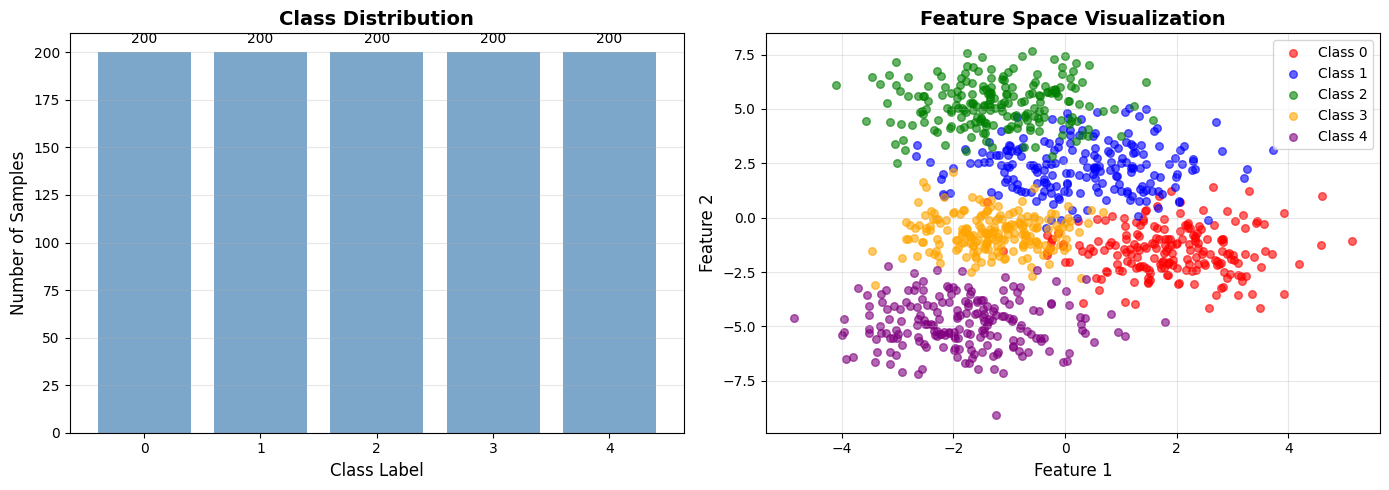

In [219]:
y_labels = np.argmax(y, axis=1)

# Create visualizations (only 2 plots)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Class distribution
ax1 = axes[0]
unique, counts = np.unique(y_labels, return_counts=True)
ax1.bar(unique, counts, color='steelblue', alpha=0.7)
ax1.set_xlabel('Class Label', fontsize=12)
ax1.set_ylabel('Number of Samples', fontsize=12)
ax1.set_title('Class Distribution', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

for label, count in zip(unique, counts):
    ax1.text(label, count + 5, str(count), ha='center', fontsize=10)

# 2. Feature distribution for first two features
ax2 = axes[1]
colors = ['red', 'blue', 'green', 'orange', 'purple']

for class_idx in range(n_classes):
    mask = y_labels == class_idx
    ax2.scatter(X[mask, 0], X[mask, 1],
                c=colors[class_idx],
                label=f'Class {class_idx}',
                alpha=0.6, s=30)

ax2.set_xlabel('Feature 1', fontsize=12)
ax2.set_ylabel('Feature 2', fontsize=12)
ax2.set_title('Feature Space Visualization', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



#**Neural Network Class Definition**

In [220]:
class NeuralNetwork:
    def __init__(self, n_features, n_classes, h1=32, h2=16, h3=8, learning_rate=0.1):
        self.learning_rate = learning_rate
        self.n_features = n_features
        self.n_classes = n_classes

        # Initialize weights using He initialization for better convergence
        self.W1 = np.random.randn(n_features, h1) * np.sqrt(2.0 / n_features)
        self.b1 = np.zeros((1, h1))

        self.W2 = np.random.randn(h1, h2) * np.sqrt(2.0 / h1)
        self.b2 = np.zeros((1, h2))

        self.W3 = np.random.randn(h2, h3) * np.sqrt(2.0 / h2)
        self.b3 = np.zeros((1, h3))

        self.W4 = np.random.randn(h3, n_classes) * np.sqrt(2.0 / h3)
        self.b4 = np.zeros((1, n_classes))

    def sigmoid(self, x, derivative=False):
        if derivative:
            return x * (1 - x)
        return 1 / (1 + np.exp(-np.clip(x, -500, 500)))

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def feedforward(self, X):
        # Layer 1
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = self.sigmoid(self.z1)

        # Layer 2
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.a2 = self.sigmoid(self.z2)

        # Layer 3
        self.z3 = np.dot(self.a2, self.W3) + self.b3
        self.a3 = self.sigmoid(self.z3)

        # Output layer with softmax
        self.z4 = np.dot(self.a3, self.W4) + self.b4
        self.output = self.softmax(self.z4)

        return self.output

    def backpropagation(self, X, y, predictions):
        m = X.shape[0]

        # Output layer error
        output_error = predictions - y
        output_delta = output_error / m

        # Hidden layer 3 error
        hidden3_error = output_delta.dot(self.W4.T)
        hidden3_delta = hidden3_error * self.sigmoid(self.a3, derivative=True)

        # Hidden layer 2 error
        hidden2_error = hidden3_delta.dot(self.W3.T)
        hidden2_delta = hidden2_error * self.sigmoid(self.a2, derivative=True)

        # Hidden layer 1 error
        hidden1_error = hidden2_delta.dot(self.W2.T)
        hidden1_delta = hidden1_error * self.sigmoid(self.a1, derivative=True)

        # Update weights and biases
        self.W4 -= self.learning_rate * self.a3.T.dot(output_delta)
        self.b4 -= self.learning_rate * np.sum(output_delta, axis=0, keepdims=True)

        self.W3 -= self.learning_rate * self.a2.T.dot(hidden3_delta)
        self.b3 -= self.learning_rate * np.sum(hidden3_delta, axis=0, keepdims=True)

        self.W2 -= self.learning_rate * self.a1.T.dot(hidden2_delta)
        self.b2 -= self.learning_rate * np.sum(hidden2_delta, axis=0, keepdims=True)

        self.W1 -= self.learning_rate * X.T.dot(hidden1_delta)
        self.b1 -= self.learning_rate * np.sum(hidden1_delta, axis=0, keepdims=True)

    def train(self, X, y):
        predictions = self.feedforward(X)
        self.backpropagation(X, y, predictions)
        return predictions

    def predict(self, X):
        predictions = self.feedforward(X)
        return np.argmax(predictions, axis=1)

#**Utility Functions**

In [221]:

def split_data(X, y, train_ratio=0.8):
    n_samples = X.shape[0]
    n_train = int(n_samples * train_ratio)

    indices = np.random.permutation(n_samples)
    train_idx = indices[:n_train]
    test_idx = indices[n_train:]

    return X[train_idx], y[train_idx], X[test_idx], y[test_idx]

def calculate_accuracy(predictions, y_true):
    y_true_labels = np.argmax(y_true, axis=1)
    return np.mean(predictions == y_true_labels)

def calculate_precision_recall_f1(predictions, y_true, n_classes):
    y_true_labels = np.argmax(y_true, axis=1)

    precision = np.zeros(n_classes)
    recall = np.zeros(n_classes)
    f1 = np.zeros(n_classes)

    for class_idx in range(n_classes):
        tp = np.sum((predictions == class_idx) & (y_true_labels == class_idx))
        fp = np.sum((predictions == class_idx) & (y_true_labels != class_idx))
        fn = np.sum((predictions != class_idx) & (y_true_labels == class_idx))

        precision[class_idx] = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall[class_idx] = tp / (tp + fn) if (tp + fn) > 0 else 0

        if (precision[class_idx] + recall[class_idx]) > 0:
            f1[class_idx] = 2 * (precision[class_idx] * recall[class_idx]) / \
                           (precision[class_idx] + recall[class_idx])
        else:
            f1[class_idx] = 0

    return precision, recall, f1

def confusion_matrix(predictions, y_true, n_classes):
    y_true_labels = np.argmax(y_true, axis=1)
    cm = np.zeros((n_classes, n_classes), dtype=int)

    for i in range(len(predictions)):
        cm[y_true_labels[i], predictions[i]] += 1

    return cm

def plot_confusion_matrix(cm, title='Confusion Matrix'):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap='Blues')
    plt.title(title, fontsize=14, fontweight='bold')
    plt.colorbar()

    n_classes = cm.shape[0]
    tick_marks = np.arange(n_classes)
    plt.xticks(tick_marks, [f'Class {i}' for i in range(n_classes)])
    plt.yticks(tick_marks, [f'Class {i}' for i in range(n_classes)])

    thresh = cm.max() / 2.
    for i in range(n_classes):
        for j in range(n_classes):
            plt.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.show()

#**Split Data into Training and Testing Sets**

In [222]:
X_train, y_train, X_test, y_test = split_data(X, y, train_ratio=0.8)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")
print(f"Training set shape: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Testing set shape: X_test={X_test.shape}, y_test={y_test.shape}")

Training set: 800 samples
Testing set: 200 samples
Training set shape: X_train=(800, 5), y_train=(800, 5)
Testing set shape: X_test=(200, 5), y_test=(200, 5)


#**Initialize Neural Network**

In [223]:
nn = NeuralNetwork(n_features=n_features, n_classes=n_classes, h1=64, h2=32, h3=16, learning_rate=0.1)

print("Architecture:")
print(f"  Input layer:    {n_features} neurons")
print(f"  Hidden layer 1: 64 neurons (sigmoid activation)")
print(f"  Hidden layer 2: 32 neurons (sigmoid activation)")
print(f"  Hidden layer 3: 16 neurons (sigmoid activation)")
print(f"  Output layer:   {n_classes} neurons (softmax activation)")
print(f"\nLearning rate: {nn.learning_rate}")
print(f"\nTotal parameters:")
print(f"  W1: {nn.W1.shape} = {nn.W1.size} parameters")
print(f"  W2: {nn.W2.shape} = {nn.W2.size} parameters")
print(f"  W3: {nn.W3.shape} = {nn.W3.size} parameters")
print(f"  W4: {nn.W4.shape} = {nn.W4.size} parameters")
total_params = nn.W1.size + nn.W2.size + nn.W3.size + nn.W4.size
total_params += nn.b1.size + nn.b2.size + nn.b3.size + nn.b4.size
print(f"  Total: {total_params} parameters")

Architecture:
  Input layer:    5 neurons
  Hidden layer 1: 64 neurons (sigmoid activation)
  Hidden layer 2: 32 neurons (sigmoid activation)
  Hidden layer 3: 16 neurons (sigmoid activation)
  Output layer:   5 neurons (softmax activation)

Learning rate: 0.1

Total parameters:
  W1: (5, 64) = 320 parameters
  W2: (64, 32) = 2048 parameters
  W3: (32, 16) = 512 parameters
  W4: (16, 5) = 80 parameters
  Total: 3077 parameters


#**Train the Neural Network**

In [224]:
print("TRAINING THE NETWORK\n")

epochs = 1000
train_losses = []
train_accuracies = []

for epoch in range(epochs):
    predictions = nn.train(X_train, y_train)

    # Calculate loss
    loss = -np.mean(y_train * np.log(predictions + 1e-8))
    train_losses.append(loss)

    # Calculate accuracy
    pred_labels = np.argmax(predictions, axis=1)
    accuracy = calculate_accuracy(pred_labels, y_train)
    train_accuracies.append(accuracy)

    # Print progress per 100 epoch
    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch + 1}/{epochs} - Loss: {loss:.4f} - Accuracy: {accuracy:.4f}")

print("\nTraining complete.")

TRAINING THE NETWORK

Epoch 100/1000 - Loss: 0.2953 - Accuracy: 0.7262
Epoch 200/1000 - Loss: 0.2309 - Accuracy: 0.7850
Epoch 300/1000 - Loss: 0.1494 - Accuracy: 0.8337
Epoch 400/1000 - Loss: 0.0978 - Accuracy: 0.9062
Epoch 500/1000 - Loss: 0.0705 - Accuracy: 0.9600
Epoch 600/1000 - Loss: 0.0519 - Accuracy: 0.9812
Epoch 700/1000 - Loss: 0.0383 - Accuracy: 0.9875
Epoch 800/1000 - Loss: 0.0290 - Accuracy: 0.9912
Epoch 900/1000 - Loss: 0.0228 - Accuracy: 0.9925
Epoch 1000/1000 - Loss: 0.0186 - Accuracy: 0.9938

Training complete.


#**Evaluate on Test Set**

In [225]:
test_predictions = nn.predict(X_test)
test_accuracy = calculate_accuracy(test_predictions, y_test)

print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)\n")

#metrices
precision, recall, f1 = calculate_precision_recall_f1(test_predictions, y_test, n_classes)

print("PER-CLASS METRICS")
print("-"*20)

print(f"{'Class':<10} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
print("-" * 50)
for i in range(n_classes):
    print(f"Class {i:<4} {precision[i]:<12.4f} {recall[i]:<12.4f} {f1[i]:<12.4f}")

print("\n" + "-" * 50)
print(f"{'Average':<10} {np.mean(precision):<12.4f} {np.mean(recall):<12.4f} {np.mean(f1):<12.4f}")



Test Accuracy: 0.9850 (98.50%)

PER-CLASS METRICS
--------------------
Class      Precision    Recall       F1-Score    
--------------------------------------------------
Class 0    1.0000       1.0000       1.0000      
Class 1    1.0000       0.9412       0.9697      
Class 2    0.9730       1.0000       0.9863      
Class 3    0.9333       1.0000       0.9655      
Class 4    1.0000       1.0000       1.0000      

--------------------------------------------------
Average    0.9813       0.9882       0.9843      


#**Visualize Training Progress**

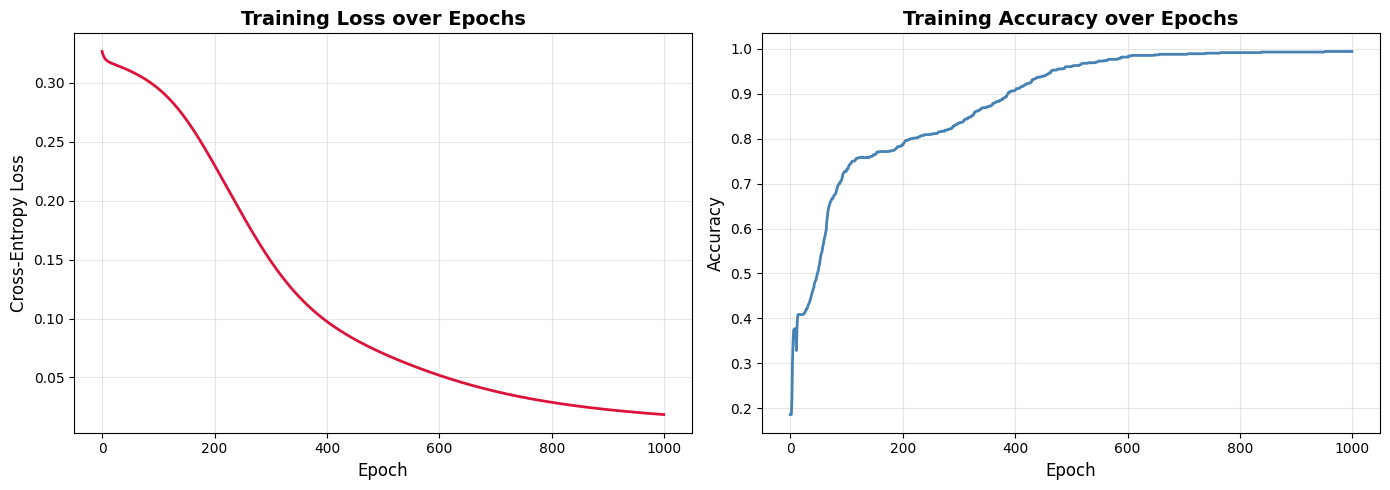

In [226]:
plt.figure(figsize=(14, 5))

#training loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, linewidth=2, color='crimson')
plt.title('Training Loss over Epochs', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Cross-Entropy Loss', fontsize=12)
plt.grid(True, alpha=0.3)

#training accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, linewidth=2, color='steelblue')
plt.title('Training Accuracy over Epochs', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


#**Visualize Confusion Matrix**

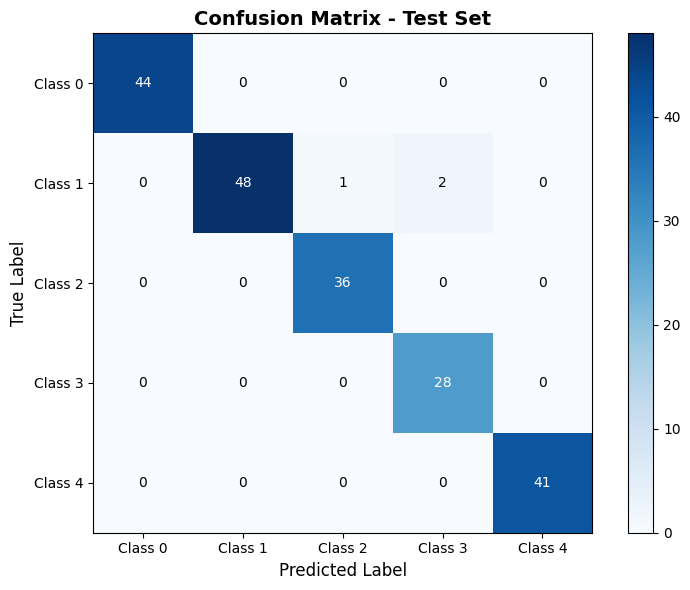

In [227]:
cm = confusion_matrix(test_predictions, y_test, n_classes)
plot_confusion_matrix(cm, title='Confusion Matrix - Test Set')

#**Summary Report**

In [229]:
print(f"\nDataset Information:")
print(f"  - Total samples: {n_samples}")
print(f"  - Features: {n_features}")
print(f"  - Classes: {n_classes}")
print(f"  - Training samples: {X_train.shape[0]}")
print(f"  - Testing samples: {X_test.shape[0]}")

print(f"\nModel Architecture:")
print(f"  - Input layer: {n_features} neurons")
print(f"  - Hidden layer 1: 32 neurons")
print(f"  - Hidden layer 2: 16 neurons")
print(f"  - Hidden layer 3: 8 neurons")
print(f"  - Output layer: {n_classes} neurons")
print(f"  - Total parameters: {total_params}")

print(f"\nTraining Configuration:")
print(f"  - Epochs: {epochs}")
print(f"  - Learning rate: {nn.learning_rate}")
print(f"  - Activation (hidden): Sigmoid")
print(f"  - Activation (output): Softmax")
print(f"  - Loss function: Cross-Entropy")

print(f"\nFinal Performance:")
print(f"  - Training accuracy: {train_accuracies[-1]:.4f} ({train_accuracies[-1]*100:.2f}%)")
print(f"  - Testing accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"  - Average precision: {np.mean(precision):.4f}")
print(f"  - Average recall: {np.mean(recall):.4f}")
print(f"  - Average F1-score: {np.mean(f1):.4f}")


Dataset Information:
  - Total samples: 1000
  - Features: 5
  - Classes: 5
  - Training samples: 800
  - Testing samples: 200

Model Architecture:
  - Input layer: 5 neurons
  - Hidden layer 1: 32 neurons
  - Hidden layer 2: 16 neurons
  - Hidden layer 3: 8 neurons
  - Output layer: 5 neurons
  - Total parameters: 3077

Training Configuration:
  - Epochs: 1000
  - Learning rate: 0.1
  - Activation (hidden): Sigmoid
  - Activation (output): Softmax
  - Loss function: Cross-Entropy

Final Performance:
  - Training accuracy: 0.9938 (99.38%)
  - Testing accuracy: 0.9850 (98.50%)
  - Average precision: 0.9813
  - Average recall: 0.9882
  - Average F1-score: 0.9843
